In [1]:
#python resample.py $IMAGE_TO_RESAMPLE $REFERENCE_IMAGE

In [2]:
#!jupyter nbconvert roi_bpress_2023-6-1.ipynb --to python

In [3]:
"""
~~~ Script description ~~~
adapted from troubshoot_bpress_slopes_6-24-22
adapted from ATM_bpress_within-between_1-4-23_rest.py on 1/31/23
- changed bpress to exclude overlap
changed path, added sys.argv for multiple jobs 5/11/23
- roi_activations_2023-05-11.npy is the same dictionary as
  mvpa_results_2023-05-11.npy with more windows and better name  
5/13
- Iterate across subs 
this script specifically looks at 28 subs for dmPFC and rTPJ
5/24
- create function that normalizes over space instead of time
6-1
- ammend for searchlight analysis w 200 schaefer rois
7-12
-copied from 6-1. rerunning for specific ROIs
"""

'\n~~~ Script description ~~~\nadapted from troubshoot_bpress_slopes_6-24-22\nadapted from ATM_bpress_within-between_1-4-23_rest.py on 1/31/23\n- changed bpress to exclude overlap\nchanged path, added sys.argv for multiple jobs 5/11/23\n- roi_activations_2023-05-11.npy is the same dictionary as\n  mvpa_results_2023-05-11.npy with more windows and better name  \n5/13\n- Iterate across subs \nthis script specifically looks at 28 subs for dmPFC and rTPJ\n5/24\n- create function that normalizes over space instead of time\n6-1\n- ammend for searchlight analysis w 200 schaefer rois\n7-12\n-copied from 6-1. rerunning for specific ROIs\n'

In [4]:
import nibabel as nib

from nilearn.input_data import NiftiMasker , MultiNiftiMasker

import nilearn as nil
"""
Plotting!
https://nilearn.github.io/plotting/index.html

"""
from nilearn import plotting
import numpy as np 
import os
import os.path
import scipy.io
import nibabel as nib
from nilearn.input_data import NiftiMasker
from nilearn.masking import compute_epi_mask
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit
from copy import deepcopy

import warnings
import sys  
import random
# import logging

import deepdish as dd
import numpy as np

import brainiak.eventseg.event
import nibabel as nib
from nilearn.input_data import NiftiMasker

import scipy.io
from scipy import stats
from scipy.stats import norm, zscore, pearsonr
from scipy.signal import gaussian, convolve
from sklearn import decomposition
from sklearn.model_selection import LeaveOneOut, KFold

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
import seaborn as sns 

sns.set(style = 'white', context='talk', font_scale=1, rc={"lines.linewidth": 2})

if not sys.warnoptions:
    warnings.simplefilter("ignore")

"""
from utils import sherlock_h5_data

if not os.path.exists(sherlock_h5_data):
    os.makedirs(sherlock_h5_data)
    print('Make dir: ', sherlock_h5_data)
else: 
    print('Data path exists')
    
from utils import sherlock_dir
"""

random.seed(10)

from brainiak import image, io
from scipy.stats import stats
import nibabel as nib
import numpy as np
from matplotlib import pyplot as plt
from brainiak import image, io

import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import LeavePGroupsOut

import pandas as pd
from nilearn.plotting import plot_glass_brain

# Import machine learning libraries
from nilearn.input_data import NiftiMasker
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, f_classif, SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from scipy.stats import sem
from copy import deepcopy
from sklearn.metrics import roc_auc_score
import statistics

from nilearn import datasets, plotting
from nilearn.input_data import NiftiSpheresMasker

from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.image import concat_imgs, resample_img, mean_img, index_img
from nilearn import image
from nilearn import masking
from nilearn.plotting import view_img
from nilearn.plotting import plot_design_matrix
from nilearn.reporting import get_clusters_table
from nilearn import input_data
from nilearn import datasets


from nilearn.plotting import plot_roi

/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [5]:
from nilearn.image import resample_to_img

# Functions 

In [6]:
## Expand / Label TRs
"""
0 = SM
1 = SC
2 = OM
3 = OC
4 = Re
requires list of labels ouputed by psychopy (column 1 - MM_self_title.started, etc.)
returns label list (order is preserved) and TR labels
"""

def label_lists(label, num_tr):
    b = [[]]
    a = []
    for i in label:
        # substring label in psychopy output
        # if the first three characters == M_s, etc, then add correct indext to string
        if i[1:4] == "M_s":
            a.append("SM")
            b.append([0]*num_tr)
        elif i[1:4] == "C_s":
            a.append("SC")
            b.append([1]*num_tr)        
        elif i[1:4] == "M_o":
            a.append("OM")
            b.append([2]*num_tr)
        elif i[1:4] == "C_o":
            a.append("OC")
            b.append([3]*num_tr)     
        else:
            a.append("Re")
            b.append([4]*num_tr)     
    return a, b[1:]
 

In [7]:
def find_cond_index(sub_ses_labels):
    """
    For the array of ordered run names (i.e.'Re', 'SM',) find the two indexes per condition
    """ 
    lab_inx = []

    a = []
    b = []
    c = []
    d = []
    e = []

    for i in enumerate(sub_ses_labels):
        if i[1] == "SM":
            # append the index according to where it appeared in the array
            a.append(i[0])
        if i[1] == "SC":
            b.append(i[0])
        if i[1] == "OM":
            c.append(i[0])
        if i[1] == "OC":
            d.append(i[0])

    # Create a dictionary where each key contains the appropriate indexes
    lab_indic = {
        'SM' : a,
        'SC' : b,
        'OM' : c,
        'OC' : d,
        'RE' : [0,9]
    }
    return lab_indic 

In [8]:
def load_epi_data(sub, ses, task,run, space):
  # Load MRI file
    if space == "MNI":
        epi_in = os.path.join(data_dir, sub, ses, 'func', "%s_%s_task-%s_run-%s_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz" % (sub, ses, task,run))
    elif space == "T1":
        epi_in = os.path.join(data_dir, sub, ses, 'func', "%s_%s_task-%s_run-%s_space-T1w_desc-preproc_bold.nii.gz" % (sub, ses, task,run))
    else:
        print("wrong load epi input. check this function")
    epi_data = nib.load(epi_in)
    print("Loading data from %s" % (epi_in))
    return epi_data

def load_roi_mask(ROI_name, space):
    if space == "MNI":
        maskdir = os.path.join(rois_dir)    
        print("expected shape: 78, 93,65")
    elif space == "T1":
        maskdir = os.path.join(rois_dir+ "/T1")
        print("expected shape: 56, 72,53")
    else:
        print("wrong mask input. check this function")
    # load the mask
    maskfile = os.path.join(maskdir, "%s.nii" % (ROI_name))
    mask = nib.load(maskfile)
    print("mask shape: ", mask.shape)
    print("Loaded %s mask" % (ROI_name))
    return mask


In [9]:
def intersect_mask(sub, num_runs,reg, ses="ses-01",task="Attn"):
    # This is based off of 'load_data' function in template
    # Loads all fMRI runs into a matrix #
    """
    reg = T1 or MNI registration?
    norm_type = by Space or by Time? 
    """
    yoz = []
    print("Begin intersecting, yeehaw")
    for run in range(1, num_runs + 1):
        # Load epi data 
        epi = load_epi_data(sub,ses,task,run,reg)
        # Load ROI data
        roi_samp = compute_epi_mask(epi)
     #   print(roi_samp)
        #nifti_masker = NiftiMasker(mask_img=roi_samp)
        #maskedData = nifti_masker.fit_transform(epi)
        yoz.append(roi_samp)
    #print(concatenated_data)
    epi_data = nil.masking.intersect_masks(yoz)
    print("all done wit da intersextion (lol)")

    return epi_data

In [10]:
# find indices of where each condition occured in 10 runs for each sub
def fnd_indices(sub,behav_p):
    behav = pd.read_csv(os.path.join(behav_p, '%s_behav_cleaned.csv') % (sub))
    # Define the column in behav to be used for creating labels # 
    label = behav.iloc[:,1]
    # Create an array of labels [1] AND the order in which runs occured [0]#
    sub_ses_labels = label_lists(label, 200)
    ## Find run sequence, extraction condition indexes from behav data ## 
    return find_cond_index(sub_ses_labels[0])

In [11]:
# organize into dict
def org_bdata_dic(unsort_bdata, run_indexes, cond_a, cond_b): 
    """
    organize two runs for concatenation
    Two runs of cond_a, then two runs of cond_b, in a dik
    
    """
    bold_dict = {}
    a = [unsort_bdata[run_indexes[cond_a][0]], unsort_bdata[run_indexes[cond_a][1]]]
    b = [unsort_bdata[run_indexes[cond_b][0]], unsort_bdata[run_indexes[cond_b][1]]]
    bold_dict[cond_a] = a
    bold_dict[cond_b] = b
    
    print("concatenated", cond_a, cond_b)
    return bold_dict

# organize into list
def org_bdata_list(unsort_bdata, run_indexes, cond_a, cond_b): 
    """
    organize two runs for concatenation
    Two runs of cond_a, then two runs of cond_b
    
    """
    bold_data = []
    a = [unsort_bdata[run_indexes[cond_a][0]], unsort_bdata[run_indexes[cond_a][1]]]
    b = [unsort_bdata[run_indexes[cond_b][0]], unsort_bdata[run_indexes[cond_b][1]]]
    print("concatenated", cond_a, cond_b)
    return a + b

def org_bdata(unsort_bdata, run_indexes, cond_a, cond_b): 
    """
    organize two runs for concatenation
    Two runs of cond_a, then two runs of cond_b
    
    """
    bold_data = []
    a = [unsort_bdata[run_indexes[cond_a][0]], unsort_bdata[run_indexes[cond_a][1]]]
    b = [unsort_bdata[run_indexes[cond_b][0]], unsort_bdata[run_indexes[cond_b][1]]]
    print("returning", cond_a, cond_b)
    return np.asarray(a), np.asarray(b)

In [12]:
suffix = "_205_noproc.npy"

# load data into a dictionary
def load_smsc_fmri_list(sub,behav_p,cond_a,cond_b,suffix,int_mask):
    cats = list(np.load(load_fmri + sub + suffix, allow_pickle =True))
    #cats = load_fMRI3d(sub, 10, "MNI", 'space', int_mask)
    # Find run labels from behavioral data
    lab_indic = fnd_indices(sub, behav_p)
    # Organize and concatenate bold data
    return org_bdata_list(cats, lab_indic, cond_a, cond_b)

# Load data into dictionary
def load_smsc_fmri_dic(sub,behav_p,cond_a,cond_b,suffix,int_mask):
    cats = list(np.load(load_fmri + sub + suffix, allow_pickle =True))
    #cats = load_fMRI3d(sub, 10, "MNI", 'space', int_mask)
    # Find run labels from behavioral data
    lab_indic = fnd_indices(sub, behav_p)
    # Organize and concatenate bold data
    return org_bdata_dic(cats, lab_indic, cond_a, cond_b)

# Rest stuff

In [13]:
def create_event_list_rest(sub, bpress, cond, cond_alt, run_dic, base_onset,comp_onset_list,stim_dur):
    """
    this function reads in a condition for each sub
    and returns the corresponding b4 + after events
    
    sub: subject number
    bpress: array of button press onset times
    cond: which condition do you want to create event dataframe fore
    """
    all_tims = []
    events = {}
    # Convert alternate bpress to array #
    bpress_arr = np.asarray(bpress[sub][cond_alt])
    # Select runs to include according to run_dic, append
    # * include runs of rest 
    all_tims = all_tims + list(bpress_arr[run_dic[sub]['RE']])
    # how much to shift from button press onset
    
    ## create fake bpress for missing data if only one run ## 
    if len(all_tims) <2 and len(run_dic[sub]['RE']) >1:
        all_tims = list(all_tims[0], all_tims[0])
        
    return all_tims

In [14]:
def load_2conds_runs_fmri(sub,behav_p,cond_a,cond_b, run_dic, suffix="_205_noproc.npy"):
    """
    read in target conditions + subject info
    output: 2 runs of condition A, as they were presented, then two runs of condition B
    """
    cats = list(np.load(load_fmri + sub + suffix, allow_pickle =True)) 
    # Find run labels from behavioral data
    lab_indic = fnd_indices(sub, behav_p)
    # Organize and concatenate bold data
    a, b = org_bdata(cats, lab_indic, cond_a, cond_b)
    # Get the indices of the runs to include #
    return list(a[run_dic[sub][cond_a]]), list(b[run_dic[sub][cond_b]])

In [15]:
def load_1cond_runs_fmri(sub,behav_p,cond_a, cond_b, run_dic, targ_run, suffix="_205_noproc.npy"):
    """
    read in target conditions + subject info
    output: 2 runs of condition A, as they were presented, then two runs of condition B
    """
    cats = list(np.load(load_fmri + sub + suffix, allow_pickle =True))
    # Find run labels from behavioral data
    lab_indic = fnd_indices(sub, behav_p)
    # Organize and concatenate bold data
    a, b = org_bdata(cats, lab_indic, cond_a, cond_b)
    # Get the indices of the runs to include #
    return list(a[run_dic[sub][cond_a]])

# Define Static VARS

In [16]:
####
data_dir = "/jukebox/graziano/coolCatIsaac/ATM/data/bids/derivatives/fmriprep/"
#rois_dir = "/jukebox/graziano/coolCatIsaac/ATM/data/work/rois/"
rois_dir = "/jukebox/graziano/coolCatIsaac/ATM/data/work/rois/results_masks/masks_mvpa"
behav_p = '/jukebox/graziano/coolCatIsaac/ATM/data/behavioral'
load_bpress = "/jukebox/graziano/coolCatIsaac/ATM/data/work/results/bpress_GLM/behav"
load_fmri = "/jukebox/graziano/coolCatIsaac/ATM/data/work/results/bpress_GLM/"
confounds = '/jukebox/graziano/coolCatIsaac/ATM/data/bids/derivatives/fmriprep/afni-head_mot/'
confounds_dir = '/jukebox/graziano/coolCatIsaac/ATM/data/work/workspace/censor_hm/'

# load whole brain mask
int_mask = nib.load('/jukebox/graziano/coolCatIsaac/ATM/data/work/workspace/load_fcma/mask_10r_n22-subs.nii.gz')

# dynamic vars

In [17]:
## sublist for rest ##
"""
no 5,8, 19, 26, 12
sub-005
 - 
sub-008

sub-019
- 
sub-012
- index range issue -- definitely due to the NO selection of runs for fMRI data -- we
select runs to be included for bpress data but not fMRI data -- need to edit
"""

### Rest Subs ### 
sub_list = ["sub-000", "sub-001","sub-002","sub-003","sub-004","sub-006","sub-007",
            "sub-009","sub-010","sub-011","sub-013","sub-014","sub-015", "sub-016","sub-017", 
            "sub-018","sub-020", "sub-021", "sub-022","sub-023","sub-024","sub-025","sub-027"]
## bad subs that do not work for rest ## 
sub_list = ["sub-000", "sub-001","sub-002","sub-003","sub-004",'sub-005', "sub-006","sub-007",'sub-008',
            "sub-009","sub-010","sub-011",'sub-012',"sub-013","sub-014","sub-015", "sub-016","sub-017", 
            "sub-018",'sub-019',"sub-020", "sub-021", "sub-022","sub-023","sub-024","sub-025", "sub-026","sub-027"]


## What threshold of head motion to extract ## 
hm_thresh = str(3)

## cluster coordinates to be extracted 
# coords = [(51,-42,44)]

In [18]:
len(sub_list)

28

# bpress data

In [19]:
## Bpress behavioral data -- overlap removed ##
bpress = dict(enumerate(np.load(os.path.join(load_bpress, "n28_4_conds_ts_press_ovrlpREMOV.npy"), 
                                allow_pickle=True).flatten(),1))[1]

In [20]:
### runs to exclude with head motion accounted for and missing bpress runs deleted
run_dic = dict(enumerate(np.load(os.path.join(confounds_dir, "n28_runs_2_include_removNoBpress_delHMruns_threshp%s.npy") %(hm_thresh), 
                                allow_pickle=True).flatten(),1))[1]

# Confounds 

In [21]:
conf_sub = dict(enumerate(np.load(os.path.join(confounds_dir, 'n28_conf+cens_MERGE_removNoBpress_delHMruns_threshp%s_glm.npy')%(hm_thresh), 
                                          allow_pickle = True).flatten(),1))[1]

# Create rest button presses 

In [22]:

"""
for sub in sub_list:
    print(sub)
    temp = []
    events_b = create_event_list_rest(sub, bpress, "RE",cond_a,run_dic,base_onset,comp_onset_list,stim_dur)
    for runs in range(len(run_dic[sub]['RE'])):
        temp.append(events_b[runs])   
    bpress.setdefault(sub, {}).setdefault('RE',temp)
"""

'\nfor sub in sub_list:\n    print(sub)\n    temp = []\n    events_b = create_event_list_rest(sub, bpress, "RE",cond_a,run_dic,base_onset,comp_onset_list,stim_dur)\n    for runs in range(len(run_dic[sub][\'RE\'])):\n        temp.append(events_b[runs])   \n    bpress.setdefault(sub, {}).setdefault(\'RE\',temp)\n'

# ROI Info

In [23]:
"""
# sublist is set up top
# sub_list = ['sub-001']

# load in target ROI
# roi = ["l_prim_motor_sm_win2_mask"]
# roi = ["dmPFC_ovlp_mask"]
# roi = ["rTPJ_mask"]

roi = ["l_prim_motor_sm_win2_mask"]
tr = 1.5
high_pass = 1/128
roi_mask = load_roi_mask(roi[0], "MNI")

# REGRESS CONFOUNDS 
##** standardize = False ??? # 


masker = NiftiMasker(mask_img=roi_mask,smoothing_fwhm=2,
                     standardize=True, detrend=True, high_pass=high_pass,
                    t_r=tr)
"""

'\n# sublist is set up top\n# sub_list = [\'sub-001\']\n\n# load in target ROI\n# roi = ["l_prim_motor_sm_win2_mask"]\n# roi = ["dmPFC_ovlp_mask"]\n# roi = ["rTPJ_mask"]\n\nroi = ["l_prim_motor_sm_win2_mask"]\ntr = 1.5\nhigh_pass = 1/128\nroi_mask = load_roi_mask(roi[0], "MNI")\n\n# REGRESS CONFOUNDS \n##** standardize = False ??? # \n\n\nmasker = NiftiMasker(mask_img=roi_mask,smoothing_fwhm=2,\n                     standardize=True, detrend=True, high_pass=high_pass,\n                    t_r=tr)\n'

# Define main function

In [24]:
def get_activations(sub_list, roi, roi_voxels, tr_range, cond_list):
    """
    Purpose:
        - extract activations from each ROI at each window, average two TRs within window
    Inputs:
        - sub_list: list of subs to iterate through
        - roi: which roi to extract activations 
        - roi_voxels: number of voxels for the selected ROI
        - tr_range: how many TRs should be averaged over?
        - cond_list: Which two conditions are we comparing
    Outputs:
        - X: Activations for every button press across subs for a given window 
        - Y: array of integers describing if button press is cond a (0) or cond b (1)
        - Groups: array of integers denoting button presses for each sub
    """
    # load in target ROI
    roi = roi
    high_pass = 1/128
    roi_mask = load_roi_mask(roi[0], "MNI")

    # Create masker object and REGRESS CONFOUNDS 
    masker = NiftiMasker(mask_img=roi_mask,smoothing_fwhm=2,
                         standardize=True, detrend=True, high_pass=high_pass,t_r=1.5)

    ## X variable corresponds to a matrix that is: roi voxels x 
    X = np.empty((0, roi_voxels))
    ## Set subject array ## 
    group_id = 0
    groups = np.array([])
    ## set array for labels ## 
    y = np.array([])

    for sub in sub_list:
        ## Which conditions? ## 
        cond_a = cond_list[0]
        cond_b = cond_list[1]

        print(sub)
        # LOAD RUNS FOR COND A AND COND B
        fmri_imgs = load_smsc_fmri_dic(sub,behav_p,cond_a,cond_b,suffix,int_mask)
        # for each condition, extract patterns for each TR and average
        for sing_cond in cond_list:
            # for each run in available run dictionairy
            for run in range(len(run_dic[sub][sing_cond])):
                temp_run = []
                print("condition: ", sing_cond)
                #temp_pred = []
                print("run", run)

                # Fit the masker object to extract a 2d matrix: voxels x TR [454, 205]
                print("sub: ", sub)
                roi_act = masker.fit_transform(fmri_imgs[sing_cond][run], confounds = conf_sub[sub][sing_cond][run])
                print(roi_act.shape)


                # extract BPRESS behavioral data # 
                linez = bpress[sub][sing_cond][run]
                print("button press TRS:", linez)

                # Average activations 
                avg_activations = []
                
                # For each TR #
                for tr in linez:
                    # Find the tr that each onset occured - convert from seconds to TR
                    print(tr)
                    tr = round(tr/1.5)
                    print(tr)
                    temp = []
                    for i in tr_range:
                        try:
                            # IF tr exists in the range of TRs add to temp array before averaging in the next step
                            temp.append(roi_act[tr+i])
                        except:
                            continue
                    print("temp length: ", len(temp))
                    # If TRs exist for this button press, add it to the array # 
                    if (len(temp) > 0):
                        X = np.vstack((X, np.mean(temp, axis=0)))
                        print("X: ", X.shape)
                        groups = np.append(groups, group_id)
                        # note that I changed this to cond_a, cond_b
                        if (sing_cond == cond_a):
                            y = np.append(y, 0)

                        elif (sing_cond == cond_b):
                            y = np.append(y, 1)


        group_id = group_id + 1
    
    return X, y, groups

In [27]:
def get_activations_spacenorm(sub_list, roi, roi_voxels, tr_range, cond_list):
    """
    Purpose:
        - extract activations from each ROI at each window, average two TRs within window
        - ** only difference from above is we changed standardize to false **
    Inputs:
        - sub_list: list of subs to iterate through
        - roi: which roi to extract activations 
        - roi_voxels: number of voxels for the selected ROI
        - tr_range: how many TRs should be averaged over?
        - cond_list: Which two conditions are we comparing
    Outputs:
        - X: Activations for every button press across subs for a given window 
        - Y: array of integers describing if button press is cond a (0) or cond b (1)
        - Groups: array of integers denoting button presses for each sub
    """
    # load in target ROI
    high_pass = 1/128
    roi_mask = roi

    # Create masker object and REGRESS CONFOUNDS 
    masker = NiftiMasker(mask_img=roi_mask,smoothing_fwhm=2,
                         standardize=False, detrend=True, high_pass=high_pass,t_r=1.5)

    ## X variable corresponds to a matrix that is: roi voxels x 
    X = np.empty((0, roi_voxels))
    ## Set subject array ## 
    group_id = 0
    groups = np.array([])
    ## set array for labels ## 
    y = np.array([])

    for sub in sub_list:
        ## Which conditions? ## 
        cond_a = cond_list[0]
        cond_b = cond_list[1]

        print(sub)
        # LOAD RUNS FOR COND A AND COND B
        fmri_imgs = load_smsc_fmri_dic(sub,behav_p,cond_a,cond_b,suffix,int_mask)
        # for each condition, extract patterns for each TR and average
        for sing_cond in cond_list:
            # for each run in available run dictionairy
            for run in range(len(run_dic[sub][sing_cond])):
                temp_run = []
                print("condition: ", sing_cond)
                #temp_pred = []
                print("run", run)

                # Fit the masker object to extract a 2d matrix: voxels x TR [454, 205]
                print("sub: ", sub)
                roi_act = masker.fit_transform(fmri_imgs[sing_cond][run], confounds = conf_sub[sub][sing_cond][run])
                print(roi_act.shape)


                # extract BPRESS behavioral data # 
                linez = bpress[sub][sing_cond][run]
                print("button press TRS:", linez)

                # Average activations 
                avg_activations = []
                
                # For each TR #
                for tr in linez:
                    # Find the tr that each onset occured - convert from seconds to TR
                    print(tr)
                    tr = round(tr/1.5)
                    print(tr)
                    temp = []
                    for i in tr_range:
                        try:
                            # IF tr exists in the range of TRs add to temp array before averaging in the next step
                            temp.append(roi_act[tr+i])
                        except:
                            continue
                    print("temp length: ", len(temp))
                    # If TRs exist for this button press, add it to the array # 
                    if (len(temp) > 0):
                        X = np.vstack((X, np.mean(temp, axis=0)))
                        print("X: ", X.shape)
                        groups = np.append(groups, group_id)
                        # note that I changed this to cond_a, cond_b
                        if (sing_cond == cond_a):
                            y = np.append(y, 0)

                        elif (sing_cond == cond_b):
                            y = np.append(y, 1)


        group_id = group_id + 1
    
    return X, y, groups

# begin

In [28]:
"""
DATA:
 - ALL_roi_activations_n28_spacenorm_2023-06-1.npy: This is activation for ALL ROIS from the schaefer atlas,copied from
     the *all* roi activations located in the searchlight folder 
 - roi_activations_n28_2023-05-14.npy : i think this is temporal norm but don't quote me
 - roi_activations_n28_spacenorm_2023-05-24.npy: spatial normalized data for two (maybe three? ) target ROIs. 
     does NOT account for the window shift [in old analysis we were off by one]
 - roi_activations_newWin_n28_spacenorm_2023-05-24.npy: *used in FINAL ANALYSIS* spatial normed with the following 
     window sizes: tr_range_dict = {'1' : np.array([-3,-4]), '2' : np.array([-1,-2]), '3' : np.array([0,1]), 
                 '4' : np.array([2,3]), '5' : np.array([4,5]), '6' : np.array([6,7]), 
                '7' : np.array([8,9]), '8' : np.array([10,11])}
  - ^^^ not sure what used in final analysis means. According to the 'final' directory, these were the window sizes used:
  tr_range_dict = {'1' : np.array([-2,-3]), '2' : np.array([0,-1]), '3' : np.array([1,2]), 
                 '4' : np.array([3,4]), '5' : np.array([5,6]), '6' : np.array([7,8]), 
                '7' : np.array([9,10]), '8' : np.array([11,12])}    

"""

"\nDATA:\n - ALL_roi_activations_n28_spacenorm_2023-06-1.npy: This is activation for ALL ROIS from the schaefer atlas,copied from\n     the *all* roi activations located in the searchlight folder \n - roi_activations_n28_2023-05-14.npy : i think this is temporal norm but don't quote me\n - roi_activations_n28_spacenorm_2023-05-24.npy: spatial normalized data for two (maybe three? ) target ROIs. \n     does NOT account for the window shift [in old analysis we were off by one]\n - roi_activations_newWin_n28_spacenorm_2023-05-24.npy: *used in FINAL ANALYSIS* spatial normed with the following \n     window sizes: tr_range_dict = {'1' : np.array([-3,-4]), '2' : np.array([-1,-2]), '3' : np.array([0,1]), \n                 '4' : np.array([2,3]), '5' : np.array([4,5]), '6' : np.array([6,7]), \n                '7' : np.array([8,9]), '8' : np.array([10,11])}\n  - ^^^ not sure what used in final analysis means. According to the 'final' directory, these were the window sizes used:\n  tr_range_dict

In [66]:
# Top Directory
top_dir = '/jukebox/graziano/coolCatIsaac/ATM/code/analysis/MVPA/schaef'
act_dir = top_dir + '/activations'
perm_dir = top_dir +'/permutations'


perm_results = perm_dir + '/perm_results'
parc_dir = "/jukebox/graziano/coolCatIsaac/ATM/data/work/rois/schaef_par/MNI/"
load_work = "/jukebox/graziano/coolCatIsaac/ATM/data/work/results/corr_data/"


In [67]:
### Set RoI ## 
#roi_dict = {'motor': ["l_prim_motor_sm_win2_mask"], 'dmPFC': ["dmPFC_ovlp_mask"], 'rTPJ': ["rTPJ_mask"]}

cond_list = [['SM', 'SC'], ['OM', 'OC']]
cond_list = [['SM', 'OM']]

## used in searchligh analysis -- i think? but i'm really not sure... -- this is EARLY window (earlyWin)
tr_range_dict = {'1' : np.array([-3,-4]), '2' : np.array([-1,-2]), '3' : np.array([0,1]), 
                 '4' : np.array([2,3]), '5' : np.array([4,5]), '6' : np.array([6,7]), 
                '7' : np.array([8,9]), '8' : np.array([10,11])}


### Save Vars ## 
date = '2023-07-17'
## activation dic ## 
act_dict_name = f'shaef_roi_activations_earlyWin_spacenorm_{date}'

#load activation dictionary
activations = np.load(os.path.join(act_dir, '%s.npy') %(act_dict_name ), allow_pickle=True).item()

## get current atlas info

In [68]:
dataset = datasets.fetch_atlas_schaefer_2018(n_rois=200)
atlas_filename = dataset.maps
labels = dataset.labels

print(f"Atlas ROIs are located in nifti image (4D) at: {atlas_filename}")

Atlas ROIs are located in nifti image (4D) at: /usr/people/isaacrc/nilearn_data/schaefer_2018/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_1mm.nii.gz


In [69]:
# set path to atlas #
schaef = "Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.nii.gz"
#schaef = "Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz"

In [70]:
## which ROI?
roi_num_one = 92

# Load in and resample ROI

In [71]:
# Load  sample data for resampling
concat = list(np.load(load_work + 'sub-007' +"_fwm7_mni_norm.npy", allow_pickle = True))
resamp_run = concat[0]
# Load parcellation
#d = nib.load(os.path.join(parc_dir + "Schaefer2018_200Parcels_17Networks_order_FSLMNI152_2mm.nii.gz"))
d = nib.load(os.path.join(parc_dir + schaef))
d_resamp = resample_to_img(d, resamp_run, interpolation='nearest')
# Get parcellation fdata
aparc = d_resamp.get_fdata()
# paracellations scheme
print(f'count parc:{len(np.unique(d_resamp.get_fdata()))}')
print("shape of d object", d_resamp.shape)

count parc:201
shape of d object (78, 93, 65)


Begin Parc 92
num voxels in one parcel: 296


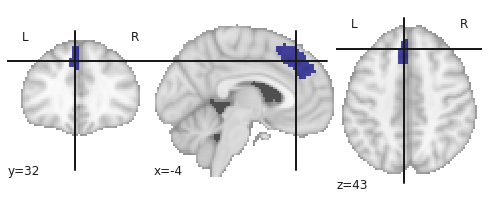

In [72]:
# View ROI # 

roi_num = roi_num_one
print("Begin Parc", roi_num)
# How many voxels for this ROI? #
num_voxels = np.sum(aparc == roi_num)
print("num voxels in one parcel:", num_voxels)
# Create an empty that is the shape of d
roi_tem = np.zeros(d_resamp.shape)
# set all cases where parcel is equal to roi_num, equal to one, everything else zero (creates a mask)
roi_tem[aparc == roi_num] = 1
# Create a nift image of the mask
roi_img = nib.Nifti1Image(roi_tem, affine = d_resamp.affine, header = d_resamp.header)
### set ROI_name #
roi_name = labels[roi_num][10:].decode("utf-8")
#nib.save(roi_img, rois_dir+'/'+ roi_name,)

plot_roi(roi_img)


## GLM ROI

In [39]:
print('doin GLM roi!')
roi_name = 'rTPJ_SM-GLM'
roi_img = load_roi_mask('SM_win1-win0_mask', 'MNI')
num_voxels = np.sum(roi_img.get_fdata() == 1) ## 400ish voxels
print(num_voxels)

doin GLM roi!
expected shape: 78, 93,65
mask shape:  (78, 93, 65)
Loaded SM_win1-win0_mask mask
416


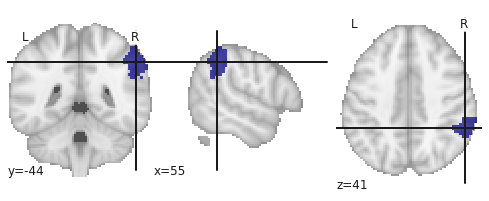

In [30]:
plot_roi(roi_img)

# run analysis - current

In [52]:
cond_list = [['SM', 'SC'], ['OM', 'OC']]

## used in searchligh analysis -- i think? but i'm really not sure... -- this is EARLY window (earlyWin)
tr_range_dict = {'3' : np.array([0,1])}
tr_range = tr_range_dict['3']

In [53]:
tr_range

array([0, 1])

In [46]:
cond_list = ['SM', 'SC']


In [47]:
high_pass = 1/128
roi_mask = roi_img

# Create masker object and REGRESS CONFOUNDS 
masker = NiftiMasker(mask_img=roi_mask,smoothing_fwhm=2,
                     standardize=False, detrend=True, high_pass=high_pass,t_r=1.5)

## X variable corresponds to a matrix that is: roi voxels x 
X = np.empty((0, num_voxels))
## Set subject array ## 
group_id = 0
groups = np.array([])
## set array for labels ## 
y = np.array([])


## Which conditions? ## 
cond_a = cond_list[0]
cond_b = cond_list[1]

print(sub)
# LOAD RUNS FOR COND A AND COND B
fmri_imgs = load_smsc_fmri_dic(sub,behav_p,cond_a,cond_b,suffix,int_mask)

sub-008
concatenated SM SC


In [49]:
for sing_cond in cond_list:
    # for each run in available run dictionairy
    for run in range(len(run_dic[sub][sing_cond])):
        temp_run = []
        print("condition: ", sing_cond)
        #temp_pred = []
        print("run", run)

        # Fit the masker object to extract a 2d matrix: voxels x TR [454, 205]
        print("sub: ", sub)
        roi_act = masker.fit_transform(fmri_imgs[sing_cond][run], confounds = conf_sub[sub][sing_cond][run])
        print(roi_act.shape)

condition:  SC
run 0
sub:  sub-008
(205, 416)


In [55]:
# extract BPRESS behavioral data # 
linez = bpress[sub][sing_cond][run]
print("button press TRS:", linez)

# Average activations 
avg_activations = []

# For each TR #
for tr in linez:
    # Find the tr that each onset occured - convert from seconds to TR
    print(tr)
    tr = int(round(tr/1.5))
    print(tr)
    temp = []
    for i in tr_range:
        try:
            # IF tr exists in the range of TRs add to temp array before averaging in the next step
            temp.append(roi_act[tr+i])
        except:
            continue
    print("temp length: ", len(temp))
    # If TRs exist for this button press, add it to the array # 
    if (len(temp) > 0):
        X = np.vstack((X, np.mean(temp, axis=0)))
        print("X: ", X.shape)
        groups = np.append(groups, group_id)
        # note that I changed this to cond_a, cond_b
        if (sing_cond == cond_a):
            y = np.append(y, 0)

        elif (sing_cond == cond_b):
            y = np.append(y, 1)

button press TRS: [ 23.6   38.66  60.68  88.31 156.35 168.56 191.98 203.03 215.67 247.73
 274.07 305.77]
23.6
16
temp length:  2
X:  (1, 416)
38.66
26
temp length:  2
X:  (2, 416)
60.68
40
temp length:  2
X:  (3, 416)
88.31
59
temp length:  2
X:  (4, 416)
156.35
104
temp length:  2
X:  (5, 416)
168.56
112
temp length:  2
X:  (6, 416)
191.98
128
temp length:  2
X:  (7, 416)
203.03
135
temp length:  2
X:  (8, 416)
215.67
144
temp length:  2
X:  (9, 416)
247.73
165
temp length:  2
X:  (10, 416)
274.07
183
temp length:  2
X:  (11, 416)
305.77
204
temp length:  1
X:  (12, 416)


In [50]:
roi_act

array([[ -1.06965626,  -3.3558311 ,  -3.79109581, ..., -12.29262829,
         -4.10826199,  -7.10734396],
       [  6.98427025,  -1.30910664, -11.46234823, ..., -15.2282064 ,
         -6.34487781,  -6.86558357],
       [  1.25738267,  -1.28081172,  -2.73571609, ...,  -7.7753311 ,
         -2.71636764,  -4.46981104],
       ...,
       [  1.37500557,  -3.27430117,  -3.05713507, ...,  12.11431426,
         -2.92485525,   5.87775132],
       [  5.41496808,   9.23655557,   1.68809559, ...,  -0.74133983,
          1.28152937,   3.14113661],
       [  0.77038765,   1.62870244,   1.17887151, ...,   3.80174683,
          1.37368945,   1.12091593]])

In [48]:
fmri_imgs

{'SM': [<nibabel.nifti1.Nifti1Image at 0x7fa1195e4990>,
 'SC': [<nibabel.nifti1.Nifti1Image at 0x7fa119425ed0>,
  <nibabel.nifti1.Nifti1Image at 0x7fa119392610>]}

In [ ]:
high_pass = 1/128
roi_mask = roi

# Create masker object and REGRESS CONFOUNDS 
masker = NiftiMasker(mask_img=roi_mask,smoothing_fwhm=2,
                     standardize=False, detrend=True, high_pass=high_pass,t_r=1.5)

## X variable corresponds to a matrix that is: roi voxels x 
X = np.empty((0, roi_voxels))
## Set subject array ## 
group_id = 0
groups = np.array([])
## set array for labels ## 
y = np.array([])

for sub in sub_list:
    ## Which conditions? ## 
    cond_a = cond_list[0]
    cond_b = cond_list[1]

    print(sub)
    # LOAD RUNS FOR COND A AND COND B
    fmri_imgs = load_smsc_fmri_dic(sub,behav_p,cond_a,cond_b,suffix,int_mask)
    # for each condition, extract patterns for each TR and average
    for sing_cond in cond_list:
        # for each run in available run dictionairy
        for run in range(len(run_dic[sub][sing_cond])):
            temp_run = []
            print("condition: ", sing_cond)
            #temp_pred = []
            print("run", run)

            # Fit the masker object to extract a 2d matrix: voxels x TR [454, 205]
            print("sub: ", sub)
            roi_act = masker.fit_transform(fmri_imgs[sing_cond][run], confounds = conf_sub[sub][sing_cond][run])
            print(roi_act.shape)


            # extract BPRESS behavioral data # 
            linez = bpress[sub][sing_cond][run]
            print("button press TRS:", linez)

            # Average activations 
            avg_activations = []

            # For each TR #
            for tr in linez:
                # Find the tr that each onset occured - convert from seconds to TR
                print(tr)
                tr = round(tr/1.5)
                print(tr)
                temp = []
                for i in tr_range:
                    try:
                        # IF tr exists in the range of TRs add to temp array before averaging in the next step
                        temp.append(roi_act[tr+i])
                    except:
                        continue
                print("temp length: ", len(temp))
                # If TRs exist for this button press, add it to the array # 
                if (len(temp) > 0):
                    X = np.vstack((X, np.mean(temp, axis=0)))
                    print("X: ", X.shape)
                    groups = np.append(groups, group_id)
                    # note that I changed this to cond_a, cond_b
                    if (sing_cond == cond_a):
                        y = np.append(y, 0)

                    elif (sing_cond == cond_b):
                        y = np.append(y, 1)


    group_id = group_id + 1

In [38]:
for conds in cond_list:
    print(conds)
    for window in tr_range_dict:
        print(f'window {window}')
        # Get activations ---- norm by space or time ? --- #
        X, y, g = get_activations_spacenorm(sub_list, roi_img, roi_voxels = num_voxels, 
                                  tr_range = tr_range_dict[window], cond_list = conds)
        ##### NORMALIZE ACROSS VOX ####
        X = zscore(X, axis = 1)
        ###
        print(X.shape)
        print(y.shape)
        print(g.shape)

        print('now save')
        # set analysis # 
        analysis = '%s_%s_%s_win%s' %(conds[0], conds[1], roi_name, window)
        # Save act dic ## 
        if os.path.isfile(os.path.join(act_dir, '%s.npy') %(act_dict_name)):
            print('exists!')
            activations = np.load(os.path.join(act_dir, '%s.npy') %(act_dict_name ), allow_pickle=True).item()
        else:
            activations = {}
            print('creating dic')
        d2 = {"X": X, "y": y, "groups":g}
        activations[analysis] = d2
        break
        #np.save(os.path.join(act_dir, '%s.npy') %(act_dict_name), activations)

['SM', 'SC']
window 3
sub-000
concatenated SM SC
condition:  SM
run 0
sub:  sub-000
(205, 416)
button press TRS: [ 94.6  115.6  154.02 221.83 269.04]
94.6
63.0
temp length:  0
115.6
77.0
temp length:  0
154.02
103.0
temp length:  0
221.83
148.0
temp length:  0
269.04
179.0
temp length:  0
condition:  SM
run 1
sub:  sub-000
(205, 416)
button press TRS: [ 27.81  59.33  74.99 103.14 126.75 154.29 167.91 190.39 208.15 225.51
 251.94 276.34 299.11]
27.81
19.0
temp length:  0
59.33
40.0
temp length:  0
74.99
50.0
temp length:  0
103.14
69.0
temp length:  0
126.75
84.0
temp length:  0
154.29
103.0
temp length:  0
167.91
112.0
temp length:  0
190.39
127.0
temp length:  0
208.15
139.0
temp length:  0
225.51
150.0
temp length:  0
251.94
168.0
temp length:  0
276.34
184.0
temp length:  0
299.11
199.0
temp length:  0
condition:  SC
run 0
sub:  sub-000
(205, 416)
button press TRS: [ 24.51  47.41  70.55  96.8  124.51 152.11 182.5  214.31 252.61 281.45]
24.51
16.0
temp length:  0
47.41
32.0
temp leng

KeyboardInterrupt: 

In [ ]:
activations

# run analysis - old

In [ ]:
for roi_num in range(roi_num_one, roi_num_one+1):
    print("Begin Parc", roi_num)
    # How many voxels for this ROI? #
    num_voxels = np.sum(aparc == roi_num)
    print("num voxels in one parcel:", num_voxels)
    # Create an empty that is the shape of d
    roi_tem = np.zeros(d_resamp.shape)
    # set all cases where parcel is equal to roi_num, equal to one, everything else zero (creates a mask)
    roi_tem[aparc == roi_num] = 1
    # Create a nift image of the mask
    roi_img = nib.Nifti1Image(roi_tem, affine = d_resamp.affine, header = d_resamp.header)
    ### set ROI_name #
    roi_name = labels[roi_num][10:].decode("utf-8")
    print(roi_name)
    for conds in cond_list:
            print(conds)
            for window in tr_range_dict:
                print(f'window {window}')
                # Get activations ---- norm by space or time ? --- #
                X, y, g = get_activations_spacenorm(sub_list, roi_img, roi_voxels = num_voxels, 
                                          tr_range = tr_range_dict[window], cond_list = conds)
                ##### NORMALIZE ACROSS VOX ####
                X = zscore(X, axis = 1)
                ###
                print(X.shape)
                print(y.shape)
                print(g.shape)

                print('now save')
                # set analysis # 
                analysis = '%s_%s_%s_win%s' %(conds[0], conds[1], roi_name, window)
                # Save act dic ## 
                if os.path.isfile(os.path.join(act_dir, '%s.npy') %(act_dict_name)):
                    print('exists!')
                    activations = np.load(os.path.join(act_dir, '%s.npy') %(act_dict_name ), allow_pickle=True).item()
                else:
                    activations = {}
                    print('creating dic')
                d2 = {"X": X, "y": y, "groups":g}
                activations[analysis] = d2
                np.save(os.path.join(act_dir, '%s.npy') %(act_dict_name), activations)

            
        



Begin Parc 92
num voxels in one parcel: 296
LH_Default_PFC_11
['OM', 'OC']
window 6
sub-000
concatenated OM OC
condition:  OM
run 0
sub:  sub-000
(205, 296)
button press TRS: [ 26.15  44.63  71.6   92.68 110.85 143.25 203.31 234.51 251.08 269.36
 286.63 296.68]
26.15
17
temp length:  2
X:  (1, 296)
44.63
30
temp length:  2
X:  (2, 296)
71.6
48
temp length:  2
X:  (3, 296)
92.68
62
temp length:  2
X:  (4, 296)
110.85
74
temp length:  2
X:  (5, 296)
143.25
96
temp length:  2
X:  (6, 296)
203.31
136
temp length:  2
X:  (7, 296)
234.51
156
temp length:  2
X:  (8, 296)
251.08
167
temp length:  2
X:  (9, 296)
269.36
180
temp length:  2
X:  (10, 296)
286.63
191
temp length:  2
X:  (11, 296)
296.68
198
temp length:  0
condition:  OC
run 0
sub:  sub-000
(205, 296)
button press TRS: [ 24.08  47.63  71.26  93.88 116.83 141.44 166.61 188.43 210.33 231.93
 255.94 288.24]
24.08
16
temp length:  2
X:  (12, 296)
47.63
32
temp length:  2
X:  (13, 296)
71.26
48
temp length:  2
X:  (14, 296)
93.88
63
tem

concatenated OM OC
condition:  OM
run 0
sub:  sub-004
(205, 296)
button press TRS: [ 31.63  55.65  82.73 155.82 188.57 221.4  234.55]
31.63
21
temp length:  2
X:  (157, 296)
55.65
37
temp length:  2
X:  (158, 296)
82.73
55
temp length:  2
X:  (159, 296)
155.82
104
temp length:  2
X:  (160, 296)
188.57
126
temp length:  2
X:  (161, 296)
221.4
148
temp length:  2
X:  (162, 296)
234.55
156
temp length:  2
X:  (163, 296)
condition:  OM
run 1
sub:  sub-004
(205, 296)
button press TRS: [ 81.32 111.03 129.3  153.58 234.48 269.8  299.16]
81.32
54
temp length:  2
X:  (164, 296)
111.03
74
temp length:  2
X:  (165, 296)
129.3
86
temp length:  2
X:  (166, 296)
153.58
102
temp length:  2
X:  (167, 296)
234.48
156
temp length:  2
X:  (168, 296)
269.8
180
temp length:  2
X:  (169, 296)
299.16
199
temp length:  0
condition:  OC
run 0
sub:  sub-004
(205, 296)
button press TRS: [ 17.59  39.4   63.87  82.17  98.85 121.27 142.08 163.22 185.88 210.03
 229.97 255.11 273.51 295.16]
17.59
12
temp length:  2
X

(205, 296)
button press TRS: [ 23.25  41.1   60.07  79.67 101.43 120.52 153.78 179.   205.18 222.56
 241.26 264.15 294.4 ]
23.25
16
temp length:  2
X:  (317, 296)
41.1
27
temp length:  2
X:  (318, 296)
60.07
40
temp length:  2
X:  (319, 296)
79.67
53
temp length:  2
X:  (320, 296)
101.43
68
temp length:  2
X:  (321, 296)
120.52
80
temp length:  2
X:  (322, 296)
153.78
103
temp length:  2
X:  (323, 296)
179.0
119
temp length:  2
X:  (324, 296)
205.18
137
temp length:  2
X:  (325, 296)
222.56
148
temp length:  2
X:  (326, 296)
241.26
161
temp length:  2
X:  (327, 296)
264.15
176
temp length:  2
X:  (328, 296)
294.4
196
temp length:  2
X:  (329, 296)
sub-007
concatenated OM OC
condition:  OM
run 0
sub:  sub-007
(205, 296)
button press TRS: [ 40.25  55.37  68.    82.12 155.6  188.92 221.03 238.08]
40.25
27
temp length:  2
X:  (330, 296)
55.37
37
temp length:  2
X:  (331, 296)
68.0
45
temp length:  2
X:  (332, 296)
82.12
55
temp length:  2
X:  (333, 296)
155.6
104
temp length:  2
X:  (334, 

(205, 296)
button press TRS: [ 17.58  39.05  62.22  94.73 116.77 136.6  163.26 192.6  208.36 254.86
 273.1  301.46]
17.58
12
temp length:  2
X:  (466, 296)
39.05
26
temp length:  2
X:  (467, 296)
62.22
41
temp length:  2
X:  (468, 296)
94.73
63
temp length:  2
X:  (469, 296)
116.77
78
temp length:  2
X:  (470, 296)
136.6
91
temp length:  2
X:  (471, 296)
163.26
109
temp length:  2
X:  (472, 296)
192.6
128
temp length:  2
X:  (473, 296)
208.36
139
temp length:  2
X:  (474, 296)
254.86
170
temp length:  2
X:  (475, 296)
273.1
182
temp length:  2
X:  (476, 296)
301.46
201
temp length:  0
condition:  OC
run 1
sub:  sub-011
(205, 296)
button press TRS: [ 22.75  47.58  74.07 142.58 167.05 256.05]
22.75
15
temp length:  2
X:  (477, 296)
47.58
32
temp length:  2
X:  (478, 296)
74.07
49
temp length:  2
X:  (479, 296)
142.58
95
temp length:  2
X:  (480, 296)
167.05
111
temp length:  2
X:  (481, 296)
256.05
171
temp length:  2
X:  (482, 296)
sub-012
concatenated OM OC
condition:  OC
run 0
sub:  s

concatenated OM OC
condition:  OM
run 0
sub:  sub-016
(205, 296)
button press TRS: [ 41.74  67.05  92.85 122.02 155.45 189.38 220.32 264.  ]
41.74
28
temp length:  2
X:  (611, 296)
67.05
45
temp length:  2
X:  (612, 296)
92.85
62
temp length:  2
X:  (613, 296)
122.02
81
temp length:  2
X:  (614, 296)
155.45
104
temp length:  2
X:  (615, 296)
189.38
126
temp length:  2
X:  (616, 296)
220.32
147
temp length:  2
X:  (617, 296)
264.0
176
temp length:  2
X:  (618, 296)
condition:  OM
run 1
sub:  sub-016
(205, 296)
button press TRS: [ 89.78 111.23 152.05 180.48 204.11 235.25 266.9  286.43]
89.78
60
temp length:  2
X:  (619, 296)
111.23
74
temp length:  2
X:  (620, 296)
152.05
101
temp length:  2
X:  (621, 296)
180.48
120
temp length:  2
X:  (622, 296)
204.11
136
temp length:  2
X:  (623, 296)
235.25
157
temp length:  2
X:  (624, 296)
266.9
178
temp length:  2
X:  (625, 296)
286.43
191
temp length:  2
X:  (626, 296)
condition:  OC
run 0
sub:  sub-016
(205, 296)
button press TRS: [ 21.53  44.3

(205, 296)
button press TRS: [ 17.55  40.14  61.54  82.12 104.38 126.05 146.28 174.75 193.15 213.6
 235.08 259.7  282.38 304.86]
17.55
12
temp length:  2
X:  (754, 296)
40.14
27
temp length:  2
X:  (755, 296)
61.54
41
temp length:  2
X:  (756, 296)
82.12
55
temp length:  2
X:  (757, 296)
104.38
70
temp length:  2
X:  (758, 296)
126.05
84
temp length:  2
X:  (759, 296)
146.28
98
temp length:  2
X:  (760, 296)
174.75
116
temp length:  2
X:  (761, 296)
193.15
129
temp length:  2
X:  (762, 296)
213.6
142
temp length:  2
X:  (763, 296)
235.08
157
temp length:  2
X:  (764, 296)
259.7
173
temp length:  2
X:  (765, 296)
282.38
188
temp length:  2
X:  (766, 296)
304.86
203
temp length:  0
condition:  OC
run 1
sub:  sub-020
(205, 296)
button press TRS: [ 24.17  47.25  71.33  93.82 116.48 140.72 166.42 188.33 210.73 231.72
 255.02 278.08 305.43]
24.17
16
temp length:  2
X:  (767, 296)
47.25
32
temp length:  2
X:  (768, 296)
71.33
48
temp length:  2
X:  (769, 296)
93.82
63
temp length:  2
X:  (770

(205, 296)
button press TRS: [ 23.8   46.67  70.43  92.52 115.68 134.45 155.25 178.77 200.62 222.93
 246.43 268.35 298.95]
23.8
16
temp length:  2
X:  (909, 296)
46.67
31
temp length:  2
X:  (910, 296)
70.43
47
temp length:  2
X:  (911, 296)
92.52
62
temp length:  2
X:  (912, 296)
115.68
77
temp length:  2
X:  (913, 296)
134.45
90
temp length:  2
X:  (914, 296)
155.25
104
temp length:  2
X:  (915, 296)
178.77
119
temp length:  2
X:  (916, 296)
200.62
134
temp length:  2
X:  (917, 296)
222.93
149
temp length:  2
X:  (918, 296)
246.43
164
temp length:  2
X:  (919, 296)
268.35
179
temp length:  2
X:  (920, 296)
298.95
199
temp length:  0
sub-024
concatenated OM OC
condition:  OM
run 0
sub:  sub-024
(205, 296)
button press TRS: [ 22.19  43.4   85.78 193.57]
22.19
15
temp length:  2
X:  (921, 296)
43.4
29
temp length:  2
X:  (922, 296)
85.78
57
temp length:  2
X:  (923, 296)
193.57
129
temp length:  2
X:  (924, 296)
condition:  OM
run 1
sub:  sub-024
(205, 296)
button press TRS: [ 85.47 119

(205, 296)
button press TRS: [ 24.15  46.75  70.62  93.88 112.1  134.97 160.1  184.88 210.   232.08
 255.98 277.   299.31]
24.15
16
temp length:  2
X:  (1054, 296)
46.75
31
temp length:  2
X:  (1055, 296)
70.62
47
temp length:  2
X:  (1056, 296)
93.88
63
temp length:  2
X:  (1057, 296)
112.1
75
temp length:  2
X:  (1058, 296)
134.97
90
temp length:  2
X:  (1059, 296)
160.1
107
temp length:  2
X:  (1060, 296)
184.88
123
temp length:  2
X:  (1061, 296)
210.0
140
temp length:  2
X:  (1062, 296)
232.08
155
temp length:  2
X:  (1063, 296)
255.98
171
temp length:  2
X:  (1064, 296)
277.0
185
temp length:  2
X:  (1065, 296)
299.31
200
temp length:  0
condition:  OC
run 1
sub:  sub-027
(205, 296)
button press TRS: [ 21.87  44.63  60.6   82.08 103.79 125.32 146.32 169.92 189.08 214.55
 243.68 269.12 290.65]
21.87
15
temp length:  2
X:  (1066, 296)
44.63
30
temp length:  2
X:  (1067, 296)
60.6
40
temp length:  2
X:  (1068, 296)
82.08
55
temp length:  2
X:  (1069, 296)
103.79
69
temp length:  2
X

(205, 296)
button press TRS: [ 86.63  99.43 152.17 203.7  234.38 257.12 269.58 294.13]
86.63
58
temp length:  2
X:  (123, 296)
99.43
66
temp length:  2
X:  (124, 296)
152.17
101
temp length:  2
X:  (125, 296)
203.7
136
temp length:  2
X:  (126, 296)
234.38
156
temp length:  2
X:  (127, 296)
257.12
171
temp length:  2
X:  (128, 296)
269.58
180
temp length:  2
X:  (129, 296)
294.13
196
temp length:  0
condition:  OC
run 0
sub:  sub-003
(205, 296)
button press TRS: [ 12.87  34.22  57.02  78.08 100.55 120.93 142.2  169.18 189.33 213.83
 229.93 254.37 277.93]
12.87
9
temp length:  2
X:  (130, 296)
34.22
23
temp length:  2
X:  (131, 296)
57.02
38
temp length:  2
X:  (132, 296)
78.08
52
temp length:  2
X:  (133, 296)
100.55
67
temp length:  2
X:  (134, 296)
120.93
81
temp length:  2
X:  (135, 296)
142.2
95
temp length:  2
X:  (136, 296)
169.18
113
temp length:  2
X:  (137, 296)
189.33
126
temp length:  2
X:  (138, 296)
213.83
143
temp length:  2
X:  (139, 296)
229.93
153
temp length:  2
X:  (

(205, 296)
button press TRS: [ 16.97  33.93  56.07  73.48  98.27 125.35 141.52 155.02 177.38 192.43
 212.22 226.55 242.5  255.93 270.65 289.96]
16.97
11
temp length:  2
X:  (298, 296)
33.93
23
temp length:  2
X:  (299, 296)
56.07
37
temp length:  2
X:  (300, 296)
73.48
49
temp length:  2
X:  (301, 296)
98.27
66
temp length:  2
X:  (302, 296)
125.35
84
temp length:  2
X:  (303, 296)
141.52
94
temp length:  2
X:  (304, 296)
155.02
103
temp length:  2
X:  (305, 296)
177.38
118
temp length:  2
X:  (306, 296)
192.43
128
temp length:  2
X:  (307, 296)
212.22
141
temp length:  2
X:  (308, 296)
226.55
151
temp length:  2
X:  (309, 296)
242.5
162
temp length:  2
X:  (310, 296)
255.93
171
temp length:  2
X:  (311, 296)
270.65
180
temp length:  2
X:  (312, 296)
289.96
193
temp length:  2
X:  (313, 296)
condition:  OC
run 1
sub:  sub-006
(205, 296)
button press TRS: [ 23.25  41.1   60.07  79.67 101.43 120.52 153.78 179.   205.18 222.56
 241.26 264.15 294.4 ]
23.25
16
temp length:  2
X:  (314, 296)

concatenated OM OC
condition:  OM
run 0
sub:  sub-011
(205, 296)
button press TRS: [ 39.48  69.21  83.21 112.53 156.43 188.78 222.18 237.91]
39.48
26
temp length:  2
X:  (445, 296)
69.21
46
temp length:  2
X:  (446, 296)
83.21
55
temp length:  2
X:  (447, 296)
112.53
75
temp length:  2
X:  (448, 296)
156.43
104
temp length:  2
X:  (449, 296)
188.78
126
temp length:  2
X:  (450, 296)
222.18
148
temp length:  2
X:  (451, 296)
237.91
159
temp length:  2
X:  (452, 296)
condition:  OM
run 1
sub:  sub-011
(205, 296)
button press TRS: [ 29.33  61.15 110.4  151.78 203.53 234.72 269.12 296.75]
29.33
20
temp length:  2
X:  (453, 296)
61.15
41
temp length:  2
X:  (454, 296)
110.4
74
temp length:  2
X:  (455, 296)
151.78
101
temp length:  2
X:  (456, 296)
203.53
136
temp length:  2
X:  (457, 296)
234.72
156
temp length:  2
X:  (458, 296)
269.12
179
temp length:  2
X:  (459, 296)
296.75
198
temp length:  0
condition:  OC
run 0
sub:  sub-011
(205, 296)
button press TRS: [ 17.58  39.05  62.22  94.73 

(205, 296)
button press TRS: [ 23.85  46.83  70.63  93.03 116.28 140.57 165.31 187.82 210.23 231.48
 254.13 277.11 304.95]
23.85
16
temp length:  2
X:  (592, 296)
46.83
31
temp length:  2
X:  (593, 296)
70.63
47
temp length:  2
X:  (594, 296)
93.03
62
temp length:  2
X:  (595, 296)
116.28
78
temp length:  2
X:  (596, 296)
140.57
94
temp length:  2
X:  (597, 296)
165.31
110
temp length:  2
X:  (598, 296)
187.82
125
temp length:  2
X:  (599, 296)
210.23
140
temp length:  2
X:  (600, 296)
231.48
154
temp length:  2
X:  (601, 296)
254.13
169
temp length:  2
X:  (602, 296)
277.11
185
temp length:  2
X:  (603, 296)
304.95
203
temp length:  0
sub-016
concatenated OM OC
condition:  OM
run 0
sub:  sub-016
(205, 296)
button press TRS: [ 41.74  67.05  92.85 122.02 155.45 189.38 220.32 264.  ]
41.74
28
temp length:  2
X:  (604, 296)
67.05
45
temp length:  2
X:  (605, 296)
92.85
62
temp length:  2
X:  (606, 296)
122.02
81
temp length:  2
X:  (607, 296)
155.45
104
temp length:  2
X:  (608, 296)
189.

(205, 296)
button press TRS: [ 36.6   56.02  85.63  98.93 136.   152.25 180.5  196.42 210.25 226.42
 255.05 271.81]
36.6
24
temp length:  2
X:  (735, 296)
56.02
37
temp length:  2
X:  (736, 296)
85.63
57
temp length:  2
X:  (737, 296)
98.93
66
temp length:  2
X:  (738, 296)
136.0
91
temp length:  2
X:  (739, 296)
152.25
102
temp length:  2
X:  (740, 296)
180.5
120
temp length:  2
X:  (741, 296)
196.42
131
temp length:  2
X:  (742, 296)
210.25
140
temp length:  2
X:  (743, 296)
226.42
151
temp length:  2
X:  (744, 296)
255.05
170
temp length:  2
X:  (745, 296)
271.81
181
temp length:  2
X:  (746, 296)
condition:  OC
run 0
sub:  sub-020
(205, 296)
button press TRS: [ 17.55  40.14  61.54  82.12 104.38 126.05 146.28 174.75 193.15 213.6
 235.08 259.7  282.38 304.86]
17.55
12
temp length:  2
X:  (747, 296)
40.14
27
temp length:  2
X:  (748, 296)
61.54
41
temp length:  2
X:  (749, 296)
82.12
55
temp length:  2
X:  (750, 296)
104.38
70
temp length:  2
X:  (751, 296)
126.05
84
temp length:  2
X

(205, 296)
button press TRS: [ 17.66  39.55  61.66  83.16 103.86 124.69 148.29 174.73 196.78 217.58
 238.82 268.91 298.54]
17.66
12
temp length:  2
X:  (888, 296)
39.55
26
temp length:  2
X:  (889, 296)
61.66
41
temp length:  2
X:  (890, 296)
83.16
55
temp length:  2
X:  (891, 296)
103.86
69
temp length:  2
X:  (892, 296)
124.69
83
temp length:  2
X:  (893, 296)
148.29
99
temp length:  2
X:  (894, 296)
174.73
116
temp length:  2
X:  (895, 296)
196.78
131
temp length:  2
X:  (896, 296)
217.58
145
temp length:  2
X:  (897, 296)
238.82
159
temp length:  2
X:  (898, 296)
268.91
179
temp length:  2
X:  (899, 296)
298.54
199
temp length:  0
condition:  OC
run 1
sub:  sub-023
(205, 296)
button press TRS: [ 23.8   46.67  70.43  92.52 115.68 134.45 155.25 178.77 200.62 222.93
 246.43 268.35 298.95]
23.8
16
temp length:  2
X:  (900, 296)
46.67
31
temp length:  2
X:  (901, 296)
70.43
47
temp length:  2
X:  (902, 296)
92.52
62
temp length:  2
X:  (903, 296)
115.68
77
temp length:  2
X:  (904, 296)

(205, 296)
button press TRS: [ 33.09  67.27  82.87 107.45 156.67 189.   214.26 234.66 267.95 287.11
 306.71]
33.09
22
temp length:  2
X:  (1032, 296)
67.27
45
temp length:  2
X:  (1033, 296)
82.87
55
temp length:  2
X:  (1034, 296)
107.45
72
temp length:  2
X:  (1035, 296)
156.67
104
temp length:  2
X:  (1036, 296)
189.0
126
temp length:  2
X:  (1037, 296)
214.26
143
temp length:  2
X:  (1038, 296)
234.66
156
temp length:  2
X:  (1039, 296)
267.95
179
temp length:  2
X:  (1040, 296)
287.11
191
temp length:  2
X:  (1041, 296)
306.71
204
temp length:  0
condition:  OC
run 0
sub:  sub-027
(205, 296)
button press TRS: [ 24.15  46.75  70.62  93.88 112.1  134.97 160.1  184.88 210.   232.08
 255.98 277.   299.31]
24.15
16
temp length:  2
X:  (1042, 296)
46.75
31
temp length:  2
X:  (1043, 296)
70.62
47
temp length:  2
X:  (1044, 296)
93.88
63
temp length:  2
X:  (1045, 296)
112.1
75
temp length:  2
X:  (1046, 296)
134.97
90
temp length:  2
X:  (1047, 296)
160.1
107
temp length:  2
X:  (1048, 

concatenated OM OC
condition:  OM
run 0
sub:  sub-003
(205, 296)
button press TRS: [ 34.74  69.27  83.   156.25 188.73 221.27]
34.74
23
temp length:  2
X:  (116, 296)
69.27
46
temp length:  2
X:  (117, 296)
83.0
55
temp length:  2
X:  (118, 296)
156.25
104
temp length:  2
X:  (119, 296)
188.73
126
temp length:  2
X:  (120, 296)
221.27
148
temp length:  2
X:  (121, 296)
condition:  OM
run 1
sub:  sub-003
(205, 296)
button press TRS: [ 86.63  99.43 152.17 203.7  234.38 257.12 269.58 294.13]
86.63
58
temp length:  2
X:  (122, 296)
99.43
66
temp length:  2
X:  (123, 296)
152.17
101
temp length:  2
X:  (124, 296)
203.7
136
temp length:  2
X:  (125, 296)
234.38
156
temp length:  2
X:  (126, 296)
257.12
171
temp length:  2
X:  (127, 296)
269.58
180
temp length:  2
X:  (128, 296)
294.13
196
temp length:  0
condition:  OC
run 0
sub:  sub-003
(205, 296)
button press TRS: [ 12.87  34.22  57.02  78.08 100.55 120.93 142.2  169.18 189.33 213.83
 229.93 254.37 277.93]
12.87
9
temp length:  2
X:  (129

(205, 296)
button press TRS: [ 16.97  33.93  56.07  73.48  98.27 125.35 141.52 155.02 177.38 192.43
 212.22 226.55 242.5  255.93 270.65 289.96]
16.97
11
temp length:  2
X:  (295, 296)
33.93
23
temp length:  2
X:  (296, 296)
56.07
37
temp length:  2
X:  (297, 296)
73.48
49
temp length:  2
X:  (298, 296)
98.27
66
temp length:  2
X:  (299, 296)
125.35
84
temp length:  2
X:  (300, 296)
141.52
94
temp length:  2
X:  (301, 296)
155.02
103
temp length:  2
X:  (302, 296)
177.38
118
temp length:  2
X:  (303, 296)
192.43
128
temp length:  2
X:  (304, 296)
212.22
141
temp length:  2
X:  (305, 296)
226.55
151
temp length:  2
X:  (306, 296)
242.5
162
temp length:  2
X:  (307, 296)
255.93
171
temp length:  2
X:  (308, 296)
270.65
180
temp length:  2
X:  (309, 296)
289.96
193
temp length:  1
X:  (310, 296)
condition:  OC
run 1
sub:  sub-006
(205, 296)
button press TRS: [ 23.25  41.1   60.07  79.67 101.43 120.52 153.78 179.   205.18 222.56
 241.26 264.15 294.4 ]
23.25
16
temp length:  2
X:  (311, 296)

concatenated OM OC
condition:  OM
run 0
sub:  sub-011
(205, 296)
button press TRS: [ 39.48  69.21  83.21 112.53 156.43 188.78 222.18 237.91]
39.48
26
temp length:  2
X:  (440, 296)
69.21
46
temp length:  2
X:  (441, 296)
83.21
55
temp length:  2
X:  (442, 296)
112.53
75
temp length:  2
X:  (443, 296)
156.43
104
temp length:  2
X:  (444, 296)
188.78
126
temp length:  2
X:  (445, 296)
222.18
148
temp length:  2
X:  (446, 296)
237.91
159
temp length:  2
X:  (447, 296)
condition:  OM
run 1
sub:  sub-011
(205, 296)
button press TRS: [ 29.33  61.15 110.4  151.78 203.53 234.72 269.12 296.75]
29.33
20
temp length:  2
X:  (448, 296)
61.15
41
temp length:  2
X:  (449, 296)
110.4
74
temp length:  2
X:  (450, 296)
151.78
101
temp length:  2
X:  (451, 296)
203.53
136
temp length:  2
X:  (452, 296)
234.72
156
temp length:  2
X:  (453, 296)
269.12
179
temp length:  2
X:  (454, 296)
296.75
198
temp length:  0
condition:  OC
run 0
sub:  sub-011
(205, 296)
button press TRS: [ 17.58  39.05  62.22  94.73 

(205, 296)
button press TRS: [ 23.85  46.83  70.63  93.03 116.28 140.57 165.31 187.82 210.23 231.48
 254.13 277.11 304.95]
23.85
16
temp length:  2
X:  (585, 296)
46.83
31
temp length:  2
X:  (586, 296)
70.63
47
temp length:  2
X:  (587, 296)
93.03
62
temp length:  2
X:  (588, 296)
116.28
78
temp length:  2
X:  (589, 296)
140.57
94
temp length:  2
X:  (590, 296)
165.31
110
temp length:  2
X:  (591, 296)
187.82
125
temp length:  2
X:  (592, 296)
210.23
140
temp length:  2
X:  (593, 296)
231.48
154
temp length:  2
X:  (594, 296)
254.13
169
temp length:  2
X:  (595, 296)
277.11
185
temp length:  2
X:  (596, 296)
304.95
203
temp length:  0
sub-016
concatenated OM OC
condition:  OM
run 0
sub:  sub-016
(205, 296)
button press TRS: [ 41.74  67.05  92.85 122.02 155.45 189.38 220.32 264.  ]
41.74
28
temp length:  2
X:  (597, 296)
67.05
45
temp length:  2
X:  (598, 296)
92.85
62
temp length:  2
X:  (599, 296)
122.02
81
temp length:  2
X:  (600, 296)
155.45
104
temp length:  2
X:  (601, 296)
189.

(205, 296)
button press TRS: [ 36.6   56.02  85.63  98.93 136.   152.25 180.5  196.42 210.25 226.42
 255.05 271.81]
36.6
24
temp length:  2
X:  (727, 296)
56.02
37
temp length:  2
X:  (728, 296)
85.63
57
temp length:  2
X:  (729, 296)
98.93
66
temp length:  2
X:  (730, 296)
136.0
91
temp length:  2
X:  (731, 296)
152.25
102
temp length:  2
X:  (732, 296)
180.5
120
temp length:  2
X:  (733, 296)
196.42
131
temp length:  2
X:  (734, 296)
210.25
140
temp length:  2
X:  (735, 296)
226.42
151
temp length:  2
X:  (736, 296)
255.05
170
temp length:  2
X:  (737, 296)
271.81
181
temp length:  2
X:  (738, 296)
condition:  OC
run 0
sub:  sub-020
(205, 296)
button press TRS: [ 17.55  40.14  61.54  82.12 104.38 126.05 146.28 174.75 193.15 213.6
 235.08 259.7  282.38 304.86]
17.55
12
temp length:  2
X:  (739, 296)
40.14
27
temp length:  2
X:  (740, 296)
61.54
41
temp length:  2
X:  (741, 296)
82.12
55
temp length:  2
X:  (742, 296)
104.38
70
temp length:  2
X:  (743, 296)
126.05
84
temp length:  2
X

(205, 296)
button press TRS: [ 17.66  39.55  61.66  83.16 103.86 124.69 148.29 174.73 196.78 217.58
 238.82 268.91 298.54]
17.66
12
temp length:  2
X:  (880, 296)
39.55
26
temp length:  2
X:  (881, 296)
61.66
41
temp length:  2
X:  (882, 296)
83.16
55
temp length:  2
X:  (883, 296)
103.86
69
temp length:  2
X:  (884, 296)
124.69
83
temp length:  2
X:  (885, 296)
148.29
99
temp length:  2
X:  (886, 296)
174.73
116
temp length:  2
X:  (887, 296)
196.78
131
temp length:  2
X:  (888, 296)
217.58
145
temp length:  2
X:  (889, 296)
238.82
159
temp length:  2
X:  (890, 296)
268.91
179
temp length:  2
X:  (891, 296)
298.54
199
temp length:  0
condition:  OC
run 1
sub:  sub-023
(205, 296)
button press TRS: [ 23.8   46.67  70.43  92.52 115.68 134.45 155.25 178.77 200.62 222.93
 246.43 268.35 298.95]
23.8
16
temp length:  2
X:  (892, 296)
46.67
31
temp length:  2
X:  (893, 296)
70.43
47
temp length:  2
X:  (894, 296)
92.52
62
temp length:  2
X:  (895, 296)
115.68
77
temp length:  2
X:  (896, 296)

In [73]:
activations = np.load(os.path.join(act_dir, '%s.npy') %(act_dict_name ), allow_pickle=True).item()
for key in sorted(activations):
    print(key)

OM_OC_LH_Cont_Cing_2_win1
OM_OC_LH_Cont_Cing_2_win6
OM_OC_LH_Cont_Cing_2_win7
OM_OC_LH_Cont_Cing_2_win8
OM_OC_LH_Cont_OFC_1_win1
OM_OC_LH_Cont_OFC_1_win2
OM_OC_LH_Cont_OFC_1_win3
OM_OC_LH_Cont_OFC_1_win4
OM_OC_LH_Cont_OFC_1_win5
OM_OC_LH_Cont_OFC_1_win6
OM_OC_LH_Cont_OFC_1_win7
OM_OC_LH_Cont_OFC_1_win8
OM_OC_LH_Cont_PFCl_1_win1
OM_OC_LH_Cont_PFCl_1_win2
OM_OC_LH_Cont_PFCl_1_win3
OM_OC_LH_Cont_PFCl_1_win4
OM_OC_LH_Cont_PFCl_1_win5
OM_OC_LH_Cont_PFCl_2_win1
OM_OC_LH_Cont_PFCl_2_win2
OM_OC_LH_Cont_PFCl_2_win3
OM_OC_LH_Cont_PFCl_2_win4
OM_OC_LH_Cont_PFCl_2_win5
OM_OC_LH_Cont_PFCl_2_win6
OM_OC_LH_Cont_PFCl_2_win7
OM_OC_LH_Cont_PFCl_2_win8
OM_OC_LH_Cont_PFCl_3_win2
OM_OC_LH_Cont_Par_1_win1
OM_OC_LH_Cont_Par_1_win2
OM_OC_LH_Cont_Par_1_win3
OM_OC_LH_Cont_Par_1_win4
OM_OC_LH_Cont_Par_1_win5
OM_OC_LH_Cont_Par_1_win6
OM_OC_LH_Cont_Par_1_win7
OM_OC_LH_Cont_Par_1_win8
OM_OC_LH_Cont_Par_2_win2
OM_OC_LH_Cont_Par_2_win3
OM_OC_LH_Cont_Par_2_win4
OM_OC_LH_Cont_Par_2_win5
OM_OC_LH_Cont_Par_3_win1
OM_OC_L

In [79]:
roi_list = ['RH_Cont_Par_2', 'LH_Default_PFC_11','RH_Default_Par_3']
roi_list = ['LH_Default_PFC_11',]
new_dic = {}
for anal in sorted(activations):
    if anal[6:-5] in roi_list:
        new_dic[anal] = activations[anal]

In [80]:
for key in new_dic:
    print(f'{key}')

OM_OC_LH_Default_PFC_11_win2
OM_OC_LH_Default_PFC_11_win3
OM_OC_LH_Default_PFC_11_win4
OM_OC_LH_Default_PFC_11_win5
SM_SC_LH_Default_PFC_11_win1
SM_SC_LH_Default_PFC_11_win2
SM_SC_LH_Default_PFC_11_win3
SM_SC_LH_Default_PFC_11_win4
SM_SC_LH_Default_PFC_11_win5
SM_SC_LH_Default_PFC_11_win6
SM_SC_LH_Default_PFC_11_win7
SM_SC_LH_Default_PFC_11_win8


In [83]:
new_dic[key]['X'].shape

(925, 296)